# Tasks

In [1]:
import datetime
import random
import re
import string
from time import sleep

import pyspark
from IPython.display import clear_output, display
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    avg,
    col,
    collect_list,
    count,
    desc,
    explode,
    from_json,
    lit,
    max,
    min,
    monotonically_increasing_id,
    udf,
    window,
)
from pyspark.sql.streaming import StreamingQuery
from pyspark.sql.types import (
    BooleanType,
    FloatType,
    IntegerType,
    StringType,
    StructType,
    TimestampType,
)

Create SparkSession in a local setup. Select your own application name. Add the `org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.1` library using the `config` function during a Spark session initialization.

### Spark Batch Processing

1. Read the data stream from file `data/titanic.csv`. Define your own schema based on information about the dataset: https://www.kaggle.com/competitions/titanic/data. Dataset was modified to include the `Timestamp` column and update schema accordingly. Display schema and the first five columns.

**Don't overwrite the original DataFrame in the following exercises unless specified otherwise.**

2. Selecting columns. For every exercise, display the first 5 rows of created DataFrame.
    * Select the `PassengerId` and `Name` columns using built-in `col` function. Add aliases for those columns: `id` and `fullname`.
    * Select all columns between the third and fifth (including those two).
    * Select columns whose names end with `-ed` (use regular expressions).

3. Columns transformations
    * Create an additional column `Constant` with the same string value `empty` in every row.
    * Create an additional column `CustomId` with new unique ids. Use `monotonicallyIncreasingId` function.
    * Rename column `Pclass` to `Class`.
    * Remove the `Cabin` and `Name` columns.

4. Filtering data - **modify original DataFrame in every step**
    * Select only passengers older than 25 years.
    * Based on min and max `Timestamp` column values (use the `collect` function to retrieve values from all nodes and save those in separate variables for filtering purposes). Select only rows that "started" 3 minutes after the first timestamp and 3 minutes before the last timestamp.
    
**Reminder**: `collect` function is used to retrieve all elements from nodes to the driver node. Be cautious with using this function on big datasets. It might cause `OutofMemoryError`.

5. Use the `pivot` function to create a table showing the average age of <ins>survivors</ins> based on their sex and travel class (`Pclass`).

The result table should look like this:

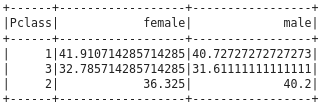

6. Explode array
    * Create a separate DataFrame with the average fare per travel class. Include the `Name` column that should be aggregated into a list of names during transformation. Use the `groupby` function.
    * Use DataFrame created in a previous step to explode the column with a list of names for the average fare. Should we expect the number of rows to be the same in the results DataFrame as in the original DataFrame before `groupby` transformation?

7. In this task we want to use the exploded table from a previous task and merge information about average fare into the original DataFrame. Use the `join` function with proper parameters. Name a new column `AvgFare` and remove the additional name column appended with the join operation.

8. Register DataFrame as a SQL temporary view using the `createOrReplaceTempView` function. Write SQL query selecting only the `PassengerId` and `Name` columns.

9. [Optional] You can register more SQL temporary views and try other SQL queries like joining and grouping.

10. Use the `map` function to create a new string column from the combined `Name`, `Sex`, and `Fare` columns. Show a few first elements of a new column. You have to convert DataFrame to RDD before using the `map` function.

11. Create UDF that will combine and transform the `Ticket`, `Cabin`, and `Embarked` columns.
    * Extract the last number from the `Ticket` column. If there isn't any number use `not_found`.
    * Convert `Cabin` letters to lowercase. If there isn't assigned cabin use `not_defined`.
    * Use full names for the `Embarked` column (use provided dictionary with mapping). If there isn't assigned embarkation location use `not_defined`.

Use UDF to merge mentioned columns into one (separated with a semicolon). Overwrite base DataFrame and display a few first rows.

In [2]:
EMBARKED_MAPPING = {"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"}

12. Save to Parquet. Do you notice any changes in the saved file structure?

If you will get an error here, usually it means that previous transformations on data can't be applied to all rows. Spark uses lazy evaluation, you have to force Spark to make calculations on all datasets (for example by using the `collect` function) unless of course you are doing transformations that must be calculated based on the whole dataset (`mean`, `min`, `max`, `groupby`).

To try to solve the problem revisit the previous point with UDF row-wise transform.

### Spark Streaming

1. Read the `titanic.csv` file as a data stream from the `data/` directory. Reuse previously implemented schema.

2. Create `writeStream` and pass a query to the `check_query` function to display transformed data. Check if all the data from CSV was correctly read. In the following tasks, you can reuse this to check the changes that you applied to your dataset. Remember to change query names between executions!

**Remember to stop the execution of the cell before moving to the next exercises (the `check_query` function is running in an infinite loop).**

In [3]:
def check_query(query: StreamingQuery, sleep_time: int = 5) -> None:
    while True:
        clear_output(wait=True)
        display(query.status)
        display(spark.sql(f"SELECT * FROM {query.name}").show())
        sleep(sleep_time)

3. From the dataset, select only passengers that:
    * did not survive the crash,
    * are older than 20 years,
    * had a third class tickets (`Pclass` column).

4. Use DataFrame from the previous point. Group results by sex and port of embarkation (`Embarked` column). Count people, calculate average passenger fare and the maximum and minimum age for every group. Name every new column as `<aggregation function>_<original_column_name>`. Remember to use the `complete` output mode to check results for aggregation queries.

5. Sort DataFrame from the previous exercise in descending order by the groups' keys.

6. [Optional] Read about windowing and watermarking in Spark Streaming (https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#window-operations-on-event-time). Use the same aggregation function from the fourth task and add tumbling windows with 5 min interval. What changed in results?

<img src="attachment:938f1999-ebc5-4ac8-a5da-e7b27350203a.png" alt="obraz.png" style="width:800px;"/>
